## Example notebook for Osteopenia prediction

### Import libraries

This is a Pytorch based example. 

In [1]:
## For neural networks
import torch
from torch import nn
from torchvision.models import vgg19, VGG19_Weights
from torchvision.models import densenet169, DenseNet169_Weights


## For class activation maps
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torchvision.transforms

## For visualisatons
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

## Define models

In this example two models will be used: VGG19 and DenseNet169

In [2]:
## Class for VGG model
class VGG(nn.Module):
    def __init__(self, pretrained_model, freeze=True):
        super().__init__()

        self.model = pretrained_model
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False

        in_features = self.model._modules['classifier'][-1].in_features
        out_features = 1

        self.model.classifier[-1] = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

## Class for DenseNet
class DenseNet(nn.Module):
    def __init__(self, pretrained_model, freeze=True):
        super().__init__()

        self.model = pretrained_model
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False

        in_features = self.model._modules['classifier'].in_features
        out_features = 1

        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
    
## Function for loading pretrained models 
def load_model(model_path, model, optimizer, device="cpu", device_ids=[0]):

    model_dict = torch.load(model_path)
  
    model = nn.DataParallel(model, device_ids=device_ids)
    model.module.load_state_dict(model_dict['model_state'])
    model = model.to(device)
    model_epoch = model_dict['epoch']

    if optimizer is not None:
        optimizer.load_state_dict(model_dict['optimizer_state'])

    return model, optimizer, model_epoch

## Model chosing function
def choose_model(name, freeze):
    if name == 'vgg19':
        return VGG(vgg19(weights=VGG19_Weights.DEFAULT), freeze=freeze)
    
    if name == 'densenet169':
        return DenseNet(densenet169(weights=DenseNet169_Weights.DEFAULT), freeze=freeze)
   

## Define image preprocessing steps

In [3]:
## Normalization and inverse normalization required for ImageNet pretrained models
def inverse_normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    inv_norm = torchvision.transforms.Normalize(
        mean = [-m/s for m, s in zip(mean, std)],
        std = [1/s for s in std]
    )
    return inv_norm(tensor)

def normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    transform = torchvision.transforms.Compose([
                        torchvision.transforms.ToPILImage(),
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize(mean=mean, std=std
    )])

    return transform(image)

## Image padding to desired size
def pad_image(image, image_desired_size):
        """
        Script for resizing the image to the desired dimensions
        First the image is resized then it is zero-padded to the desired
        size given in the argument

        Args:
            * image_desired_dimension, int, new size of the image

        Output:
            * None, image is updated
        """
        # Grab the old_size
        _old_size = image.shape[:2]  # old_size is in (height, width) format
        # Calculate new size
        _ratio = float(image_desired_size) / max(_old_size)
        _new_size = tuple([int(_x * _ratio) for _x in _old_size])

        # new_size should be in (width, height) format
        image = cv2.resize(image, (_new_size[1], _new_size[0]))

        # Calculate padding
        _delta_w = image_desired_size - _new_size[1]
        _delta_h = image_desired_size - _new_size[0]
        _top, _bottom = _delta_h // 2, _delta_h - (_delta_h // 2)
        _left, _right = _delta_w // 2, _delta_w - (_delta_w // 2)

        # Pad
        color = [0, 0, 0]

        image = cv2.copyMakeBorder(image, _top, _bottom, _left, _right, cv2.BORDER_CONSTANT, value=color)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        return image

## Image loading from file
def load_image(image_path, image_size=512):

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = pad_image(img, image_size)

    return normalize(img)

## Prediction scripts

In [4]:
def generate_heatmap(model_path, model_name, input_tensor, input_label, device="cpu"):

    model = choose_model(model_name, freeze=False)
    model, _, model_epoch = load_model(model_path, model, None, device)
    model = model.module.model
    
    target_layers = [model.features[-1]]
    
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(0)]
    
    input_tensor = input_tensor.to(device)
    input_tensor = torch.unsqueeze(input_tensor, 0)
    
    pred = model(input_tensor).item()
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True)

    input_tensor = torch.squeeze(input_tensor, 0)
    input_tensor = inverse_normalize(input_tensor)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(input_tensor.permute(1, 2, 0).numpy(), grayscale_cam, use_rgb=True)

    f, axarr = plt.subplots(1, 2, figsize=(10, 8))
    f.tight_layout()
    f.suptitle(f'Osteopenia classification', fontsize=20)

    axarr[0].imshow(input_tensor.permute(1, 2, 0))
    axarr[0].axis('off')
    axarr[0].set_title(f'Original image\nGround truth = {input_label == 1}\n', fontsize=16)
    axarr[1].imshow(visualization)
    axarr[1].axis('off')
    axarr[1].set_title(f'{model_name}\nPredicted = {pred > 0.5},\n{pred:.3f}\n', fontsize=16)
    
def predict_on_image(model_path, model_name, input_tensor, input_label, device = "cpu"):
    model = choose_model(model_name, freeze=False)
    model, _, model_epoch = load_model(model_path, model, None, device)
    model = model.module.model
    
    input_tensor = input_tensor.to(device)
    input_tensor = torch.unsqueeze(input_tensor, 0)
    
    pred = model(input_tensor).item()
    input_tensor = torch.squeeze(input_tensor, 0)
    input_tensor = inverse_normalize(input_tensor)
    plt.figure(figsize=(10, 8))
    plt.tight_layout()
    plt.imshow(input_tensor.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f'Osteopenia classification\nGround truth = {input_label == 1} '+
                       f'Predicted = {pred > 0.5},\n{pred:.3f}\n', fontsize=12)

## Model selection

In [5]:
# Choose model: vgg19 or densenet169
#model_path = 'models/best-densenet169.pt'
model_path = 'models/best-vgg19.pt'
#model_name = 'densenet169'
model_name = 'vgg19'
device="cpu"

## Image selection

In [6]:
## List all images
_images_names = [_file for _file in os.listdir("images") if _file.endswith(".png")]
## Images labels
_input_df = pd.read_csv('images/labels.csv')

## Choose image
_image_index = 4 # This can be changed to any number between 0 and 9
_image_path = "images/"+str(_images_names[_image_index])

## Obtain image info
_input_label = int(_input_df[_input_df['filestem'] == _image_path].iloc[0, 1])
_input_tensor = load_image(_image_path)

## Do model prediction - input image, label and models prediction

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/franko/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|████████████████████████████████████████| 548M/548M [00:05<00:00, 97.8MB/s]


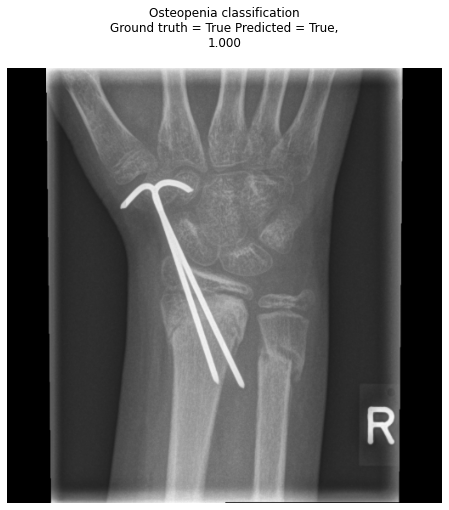

In [7]:
predict_on_image(model_path, model_name, _input_tensor, _input_label, device)

## Do prediction with GRADCAM which shows a heatmap of which pixels contributed most towards model decision

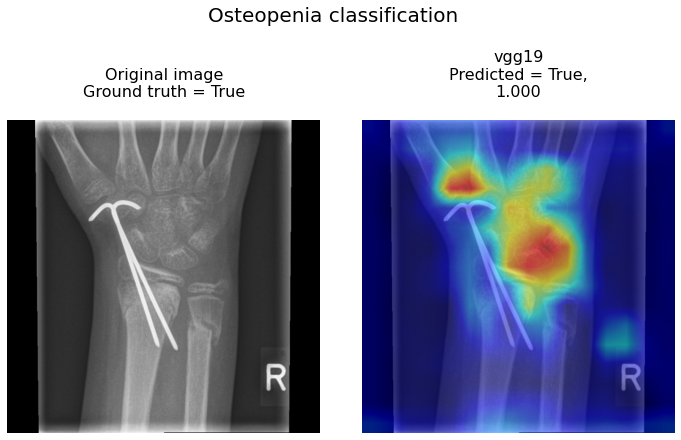

In [8]:
generate_heatmap(model_path, model_name, _input_tensor, _input_label, device)